# Loading data

In [2]:
import uproot as up
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('seaborn-v0_8-paper')
plt.rcParams["patch.force_edgecolor"] = True

In [3]:
all_feature = pd.read_csv("all_features.csv")

# Balancing the dataset

In [4]:
print("BKG: ", all_feature["delta_time"][all_feature['Label']==0].shape[0])
print("IBD: ", all_feature["delta_time"][all_feature['Label']==1].shape[0]) 

BKG:  1000081
IBD:  1468385


In [5]:
# Elimina gli elementi desiderati dal dataset
num_IBD = all_feature["delta_time"][all_feature['Label']==1].shape[0]
num_BKG = all_feature["delta_time"][all_feature['Label']==0].shape[0]

del_BKG = 0
del_IBD = 0

if num_IBD > num_BKG:
    del_IBD = num_IBD - num_BKG
    to_del_ibd = all_feature.shape[0] - del_IBD
    order = np.argsort(all_feature["Label"])
    all_feature = all_feature.iloc[order].dropna()
    all_feature = all_feature.iloc[:to_del_ibd]

elif num_IBD < num_BKG:
    del_BKG = num_BKG - num_IBD
    order = np.argsort(all_feature["Label"])
    all_feature = all_feature.iloc[order].dropna()
    all_feature = all_feature.iloc[del_BKG:]

print("BKG:", all_feature["Label"][all_feature['Label']==0].shape[0]) 
print("IBD:",  all_feature["Label"][all_feature['Label']==1].shape[0])

BKG: 1000081
IBD: 1000081


## Creating train and test datasets

In [6]:
from sklearn.model_selection import train_test_split


columns_to_exclude = ['Label', 'Source']


X = all_feature.drop(columns_to_exclude, axis=1)
Y = all_feature['Label']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=.1)

In [7]:
X_train.describe()

,E_pro,delta_radius,E_del,R_delayed,delta_time,R_prompt
count,1.440116e+06,1.440116e+06,1.440116e+06,1.440116e+06,1.440116e+06,1.440116e+06
mean,2.142754e+00,1.059720e+04,1.533608e+00,1.424008e+04,3.807271e+05,1.424815e+04
std,2.185584e+00,1.148072e+04,1.610218e+00,3.497856e+03,3.144673e+05,3.488592e+03
min,0.000000e+00,1.430035e+00,0.000000e+00,0.000000e+00,6.400000e+02,3.947012e-06
25%,5.691675e-01,3.317270e+02,5.678132e-01,1.220046e+04,1.106400e+05,1.220638e+04
50%,1.797150e+00,1.983826e+03,2.132120e+00,1.531727e+04,2.885520e+05,1.532756e+04
75%,3.291340e+00,2.113134e+04,2.219740e+00,1.739900e+04,6.107840e+05,1.739900e+04
max,3.913881e+02,3.479763e+04,3.913881e+02,1.740007e+04,1.099999e+06,1.740007e+04


## PyTorch Neural Network

In [8]:
type(X_train[1:1+4].values)

numpy.ndarray

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score

# cuda, se disponibile
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definire il DataSet personalizzato
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_normed = scaler.transform(X_train)
X_test_normed = scaler.transform(X_test)
X_validation_normed = scaler.transform(X_validation)
    
# Creare i set di dati personalizzati
train_dataset = CustomDataset(torch.from_numpy(X_train_normed).float(), torch.from_numpy(y_train.values).long())
test_dataset = CustomDataset(torch.from_numpy(X_test_normed).float(), torch.from_numpy(y_test.values).long())
validation_dataset = CustomDataset(torch.from_numpy(X_validation_normed).float(), torch.from_numpy(y_validation.values).long())

# Creare i DataLoader
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=256, shuffle=True)


In [10]:
import os
from tqdm import tqdm

# Definire la rete neurale
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)  # num features from X_train
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 64)
        self.fc6 = nn.Linear(64, 2)  # num classes from y_train

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        # x = torch.sigmoid(self.fc6(x)) #sigmoid
        x = self.fc6(x) 
        return x

# Istanziare la rete e spostarla su cuda  
net = Net().to(device)

# Definire la loss function e l'optimizer
criterion = nn.CrossEntropyLoss()  # Usando la CrossEntropy come funzione di perdita per la classificazione
# criterion = nn.BCEWithLogitsLoss()  # Usando la CrossEntropy come funzione di perdita per la classificazione
optimizer = optim.Adam(net.parameters())

model_path = "def.pth"
# model_path = "torch_net_normed_def.pth"

# Controllare se esiste un file contenente il modello addestrato
if os.path.isfile(model_path):
    # Caricare il modello
    net.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    net.eval()
    print("Model loaded")
else:
    # Addestrare la rete
    min_valid_loss = np.inf
    early_stop_steps = 0
    early_stopping_rounds = 10
    for epoch in tqdm(range(2000)):  # 100 epoche
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # labels = labels.unsqueeze(1)
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
    
        valid_loss = 0.0
        net.eval()     # Optional when not using Model Specific layer
        for data, labels in validation_loader:
            data, labels = data.cuda(), labels.cuda()
            # labels = labels.unsqueeze(1)
            target = net(data)
            loss = criterion(target,labels)
            valid_loss += loss.item()

        print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(validation_loader)}')
        if min_valid_loss > valid_loss:
            early_stop_steps = 0
            min_valid_loss = valid_loss
        else:
            early_stop_steps+=1
            if early_stop_steps >= early_stopping_rounds:
                break


    print('Finished Training')

    # Salvare il modello
    torch.save(net.state_dict(), model_path)

# Calcolare l'accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)

        # probs_normed = nnf.softmax(outputs, dim=1)
        # _, predicted = probs_normed.topk(1, dim = 1)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test data: %d %%' % (100 * correct / total))


Model loaded
Accuracy of the network on the test data: 99 %


In [11]:
correct / total

0.9998100156737069

In [12]:
correct, y_test.shape

(399957, (400033,))

In [13]:
torch.max(outputs.data, 1)

torch.return_types.max(
values=tensor([5.4002e+00, 4.9479e+00, 5.3637e+00, 5.2684e+02, 4.8443e+00, 5.3315e+00,
        3.6140e+02, 1.8222e+02, 5.8595e+01, 5.7476e+00, 2.2419e+02, 5.2418e+00,
        4.4621e+00, 2.8850e+02, 3.1886e+02, 5.2912e+00, 1.8848e+02, 3.1540e+02,
        5.7498e+00, 5.1005e+00, 2.1596e+02, 5.2485e+00, 3.3555e+02, 4.7525e+00,
        4.2563e+00, 2.9075e+02, 4.7697e+02, 2.0240e+02, 4.3665e+00, 1.5845e+02,
        1.8312e+02, 4.9975e+00, 3.5864e+02, 2.3670e+02, 5.8297e+00, 5.6686e+00,
        4.2918e+00, 3.5687e+02, 4.9329e+00, 5.4855e+00, 1.6727e+02, 8.9628e+01,
        2.1793e+02, 2.3610e+00, 2.8755e+02, 2.2248e+02, 5.5954e+00, 1.4287e+02,
        4.0027e+00, 9.0673e+01, 4.5349e+00, 4.6009e+00, 1.7941e+02, 3.5505e+02,
        5.3334e+00, 2.6529e+02, 5.0362e+00, 1.1090e+02, 4.7152e+00, 4.6356e+00,
        4.6547e+02, 3.1365e+00, 5.6104e+00, 5.4720e+00, 5.3735e+00, 2.3164e+02,
        9.5037e+01, 6.2839e+01, 4.1944e+02, 1.3742e+02, 1.5634e+02, 4.1397e+02,
        5

In [14]:

import torch.nn.functional as nnf
input_tensor = torch.tensor(X_test_normed, dtype=torch.float32).to('cpu')

# y_pred = net(torch.from_numpy(X_test_normed).float().cpu())#,  dtype = torch.float32)

probs = net(input_tensor).to('cpu')
probs_normed = nnf.softmax(probs, dim=1).to('cpu')
probs_normed

tensor([[1.0000e+00, 4.8936e-26],
        [1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00],
        ...,
        [7.6284e-06, 9.9999e-01],
        [1.0579e-04, 9.9989e-01],
        [8.0759e-05, 9.9992e-01]], grad_fn=<SoftmaxBackward0>)

In [15]:
import sklearn
import torch.nn.functional as nnf

input_tensor = torch.tensor(X_test_normed, dtype=torch.float32).to('cpu')

y_pred = net(torch.from_numpy(X_test_normed).float().cpu())#,  dtype = torch.float32)

probs = net(input_tensor).to('cpu')
probs_normed = nnf.softmax(probs, dim=1).to('cpu')
p_, y_pred = probs_normed.topk(1, dim = 1)


print(sklearn.metrics.classification_report(y_test, y_pred))
sklearn.metrics.confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    200277
         1.0       1.00      1.00      1.00    199756

    accuracy                           1.00    400033
   macro avg       1.00      1.00      1.00    400033
weighted avg       1.00      1.00      1.00    400033



array([[200231,     46],
       [    30, 199726]])

In [23]:
y_pred.numpy().flatten()

array([0, 0, 0, ..., 1, 1, 1])

In [38]:
TP = np.logical_and(y_test == 1, y_pred.numpy().flatten() == 1)
TN = np.logical_and(y_test == 0, y_pred.numpy().flatten() == 0)
FN = np.logical_and(y_test == 1, y_pred.numpy().flatten() == 0)
FP = np.logical_and(y_test == 0, y_pred.numpy().flatten() == 1) 

print(TP.sum())
print(TN.sum())
print(FP.sum())
print(FN.sum())

print(TP.sum(),"/", TP.sum() , '+', FP.sum())
import sklearn

print("Efficiency IBD: ", (TP.sum()/(TP.sum()+FN.sum())))
print("Efficiency BKG: ", (TN.sum()/(TN.sum()+FP.sum())))

sklearn.metrics.confusion_matrix(y_test, y_pred.numpy().flatten())

199726
200231
46
30
199726 / 199726 + 46
Efficiency IBD:  0.9998498167764673
Efficiency BKG:  0.9997703181094184


array([[200231,     46],
       [    30, 199726]])

# $\Delta t$ vs $\Delta R$

In [15]:
to_plot_tensor = torch.tensor(X_test[:2000].values, dtype=torch.float32).to('cpu')
probs = net(to_plot_tensor).to('cpu')
probs_normed = nnf.softmax(probs, dim=1).to('cpu')
probs_normed

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]], grad_fn=<SoftmaxBackward0>)

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as nnf

to_plot = pd.DataFrame()
dr_array = np.linspace(0, 3000, 1000)
# dt_array = np.linspace(0, 20*220e3, 1000)
dt_array = np.linspace(0, 5*220e3, 1000)
# dr_array = np.linspace(0, 3000, 1000)
# dt_array = np.linspace(0, 20*220e3, 1000)
dr_mesh, dt_mesh = np.meshgrid(dr_array, dt_array)
elements = len(dr_mesh.flatten())

Radius = np.linspace(0,17600,100).astype(int)
R = Radius[99]
print(R)


to_plot['R_prompt'] = R*np.ones(elements)
to_plot['R_delayed'] = R*np.ones(elements)
to_plot['E_pro'] = 1.*np.ones(elements)
to_plot['delta_radius'] = dr_mesh.flatten()
to_plot['E_del'] = 2.2*np.ones(elements)
to_plot['delta_time'] = dt_mesh.flatten()
to_plot = to_plot[X.columns]
to_plot = scaler.transform(to_plot)

#utilizza net per fare previsione sui dati contenuti in to_plot.
to_plot_tensor = torch.tensor(to_plot, dtype=torch.float32).to('cpu')
probs = net(to_plot_tensor).to('cpu')
probs_normed = probs
probs_normed = nnf.softmax(probs, dim=1).to('cpu')
probs_normed = probs_normed[:, 1].reshape(dr_mesh.shape)
# plt.imshow(probs_normed.detach().numpy(), cmap = 'Blues', origin = 'lower', extent = (dr_mesh.min(), dr_mesh.max(), dt_mesh.min(), dt_mesh.max()), aspect = 'auto', vmin = 0.95, vmax = 1)
# #plt.scatter(all_feature["delta_radius"][all_feature['Label']==1], all_feature["delta_time"][all_feature['Label']==1])
# plt.xlabel(r'$\Delta$R [mm]')
# plt.ylabel(r'$\Delta$t [ns]')

   

17600


/tmp/ipykernel_9161/2132706676.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


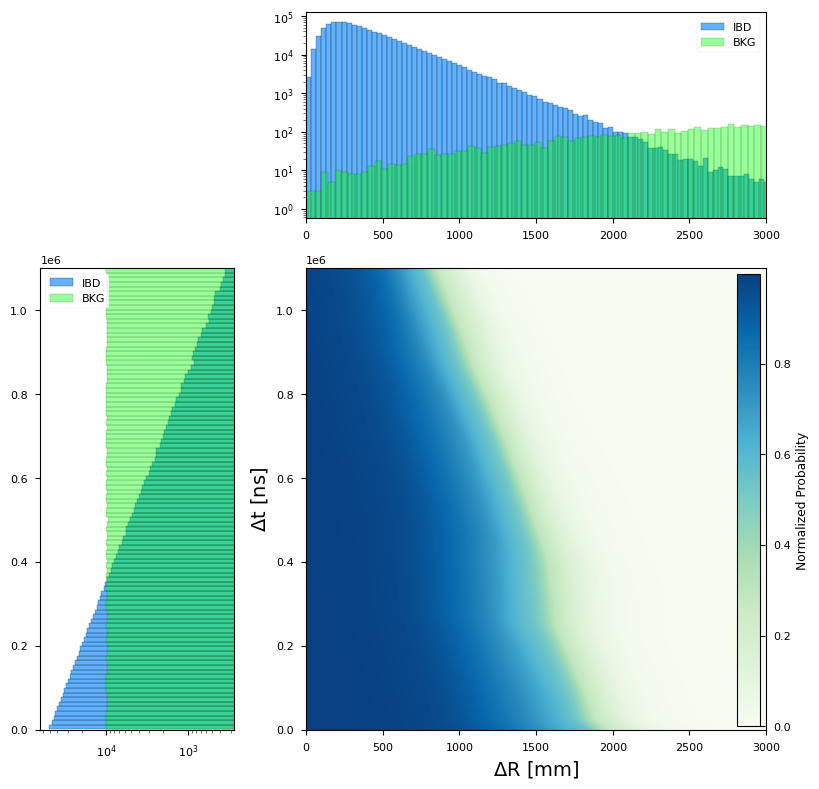

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as nnf
import torch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig = plt.figure(figsize=(8, 8))

# Crea un subplot per il grafico principale
ax1 = plt.subplot2grid((3, 3), (1, 1), colspan=2, rowspan=2)

# Aggiungi un'etichetta al grafico imshow
immagine = ax1.imshow(probs_normed.detach().numpy(), cmap='GnBu', origin='lower', extent=(dr_mesh.min(), dr_mesh.max(), dt_mesh.min(), dt_mesh.max()), aspect='auto')

ax1.set_xlabel(r'$\Delta$R [mm]', fontsize = 14)
ax1.set_ylabel(r'$\Delta$t [ns]', fontsize = 14)

# Crea un set di assi all'interno del grafico principale per la barra dei colori
axins = inset_axes(ax1, width="5%", height="98%", loc='upper right')
cbar = plt.colorbar(immagine, cax=axins, orientation='vertical', label='Normalized Probability')

# Crea un subplot per l'istogramma delta_r
ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=2, sharex=ax1)

# Calcola e disegna l'istogramma, e rimuovi gli assi duplicati
# Aggiungi un'etichetta all'istogramma
_, bins, _ = ax2.hist(all_feature["delta_radius"][all_feature["Label"] == 1], bins=800, color='dodgerblue', alpha=0.7, label='IBD',log=True)
_, bins, _ = ax2.hist(all_feature["delta_radius"][all_feature["Label"] == 0], bins=800, color='lime', alpha=0.4, label='BKG',log=True)

ax2.legend() # Mostra la legenda
ax2.set_xlim(0, 3000)

# Crea un subplot per l'istogramma delta_t
ax3 = plt.subplot2grid((3, 3), (1, 0), rowspan=2, sharey=ax1)

# Calcola e disegna l'istogramma, e rimuovi gli assi duplicati
# Aggiungi un'etichetta all'istogramma
_, bins, _ = ax3.hist(all_feature["delta_time"][all_feature["Label"] == 1], bins=100, orientation='horizontal', color='dodgerblue', alpha=0.7, label='IBD',log=True)
_, bins, _ = ax3.hist(all_feature["delta_time"][all_feature["Label"] == 0], bins=100, orientation='horizontal', color='lime', alpha=0.4, label='BKG',log=True)

ax3.legend() # Mostra la legenda
ax3.invert_xaxis()

plt.tight_layout()

plt.savefig('../../../../Latex/Images/dr_dt_pytorch.png')

plt.show()


In [18]:
to_plot = pd.DataFrame()

dr_array = np.linspace(0, 7100, 1000)
R_array = np.linspace(0, 17700, 1000)

dr_mesh, R_mesh = np.meshgrid(dr_array, R_array)

elements = len(dr_mesh.flatten())
to_plot['R_prompt'] = R_mesh.flatten()
to_plot['R_delayed'] = to_plot['R_prompt']
to_plot['E_pro'] = 1.*np.ones(elements)
to_plot['delta_radius'] = dr_mesh.flatten()
to_plot['E_del'] = 2.2*np.ones(elements)
to_plot['delta_time'] = 220e3
to_plot = to_plot[X.columns]
to_plot = scaler.transform(to_plot)


#utilizza net per fare previsione sui dati contenuti in to_plot.
to_plot_tensor = torch.tensor(to_plot, dtype=torch.float32).to('cpu')
probs = net(to_plot_tensor).to('cpu')
probs_normed_n = nnf.softmax(probs, dim=1).to('cpu')
probs_normed_n = probs_normed_n[:, 1].reshape(dr_mesh.shape)

# plt.contourf(probs_normed_n.detach().numpy(), cmap = 'Blues', origin = 'lower', extent = (dr_mesh.min(), dr_mesh.max(), R_mesh.min(), R_mesh.max()), aspect = 'auto', vmin = 0., vmax=0.1, levels = 200)

# plt.xlabel(r'$\Delta$R [mm]')
# plt.ylabel(r'R [mm]')

/tmp/ipykernel_9161/946809480.py:8: UserWarning: The following kwargs were not used by contour: 'aspect'
  immagine = ax1.contourf(probs_normed_n.detach().numpy(), cmap = 'GnBu', origin = 'lower', extent = (dr_mesh.min(), dr_mesh.max(), R_mesh.min(), R_mesh.max()), aspect = 'auto',  levels = 200)
/tmp/ipykernel_9161/946809480.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


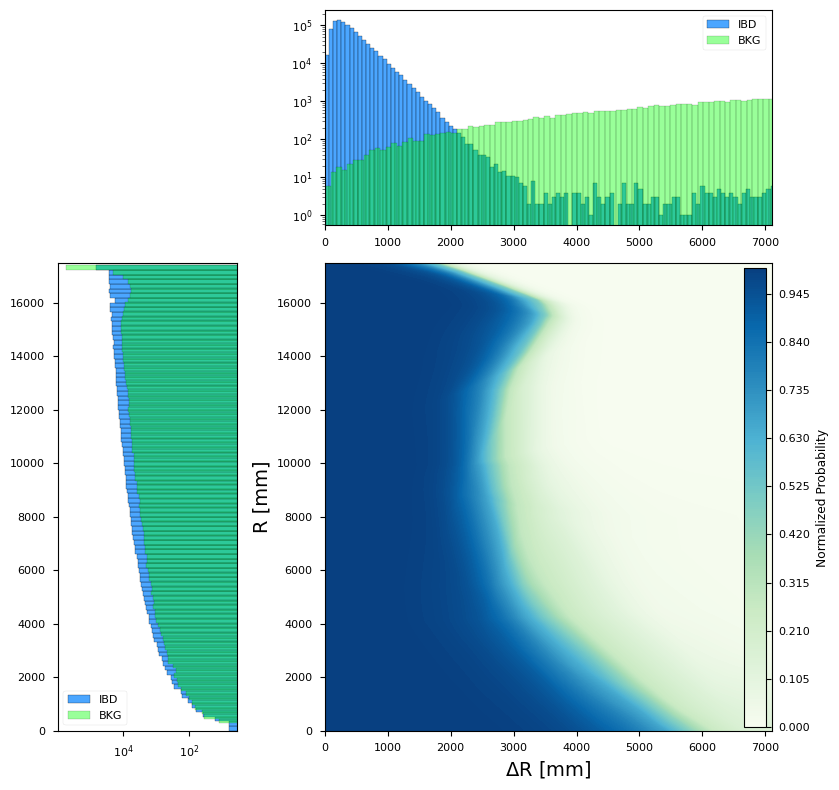

In [19]:
fig = plt.figure(figsize=(8, 8))

# Crea un subplot per il grafico principale
ax1 = plt.subplot2grid((3, 3), (1, 1), colspan=2, rowspan=2)



immagine = ax1.contourf(probs_normed_n.detach().numpy(), cmap = 'GnBu', origin = 'lower', extent = (dr_mesh.min(), dr_mesh.max(), R_mesh.min(), R_mesh.max()), aspect = 'auto',  levels = 200)

ax1.set_xlabel(r'$\Delta$R [mm]', fontsize = 14)
ax1.set_ylabel(r'R [mm]', fontsize = 14)

# Crea un set di assi all'interno del grafico principale per la barra dei colori
axins = inset_axes(ax1, width="5%", height="98%", loc='upper right')
cbar = plt.colorbar(immagine, cax=axins, orientation='vertical', label='Normalized Probability')

# Crea un subplot per l'istogramma delta_r
ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=2, sharex=ax1)

# Calcola e disegna l'istogramma, e rimuovi gli assi duplicati
# Aggiungi un'etichetta all'istogramma
_, bins, _ = ax2.hist(all_feature["delta_radius"][all_feature["Label"] == 1], bins=400, color='dodgerblue', alpha=0.8, label='IBD', log= True)
_, bins, _ = ax2.hist(all_feature["delta_radius"][all_feature["Label"] == 0], bins=400, color='lime', alpha=0.4, label='BKG', log= True)

ax2.legend() # Mostra la legenda
ax2.set_xlim(0, 7100)

# Crea un subplot per l'istogramma delta_t
ax3 = plt.subplot2grid((3, 3), (1, 0), rowspan=2, sharey=ax1)
ax3.set_ylim(0, 17500)

# Calcola e disegna l'istogramma, e rimuovi gli assi duplicati
# Aggiungi un'etichetta all'istogramma

_, bins, _ = ax3.hist(all_feature["R_prompt"][all_feature["Label"] == 1], bins=100, orientation='horizontal', color='dodgerblue', alpha=0.8, label='IBD', log= True)
_, bins, _ = ax3.hist(all_feature["R_prompt"][all_feature["Label"] == 0], bins=100, orientation='horizontal', color='lime', alpha=0.4, label='BKG', log= True)

ax3.legend() # Mostra la legenda
ax3.invert_xaxis()

plt.tight_layout()

plt.savefig('../../../../Latex/Images/dr_r_pytorch.png')
plt.show()

In [20]:
# to_plot = pd.DataFrame()

# dr_array = np.linspace(0, 6000, 1000)
# dt_array = np.linspace(0, 5*220e3, 1000)

# R = 0
# dr_mesh, dt_mesh = np.meshgrid(dr_array, dt_array)
# elements = len(dr_mesh.flatten())
# to_plot['R_prompt'] = R*np.ones(elements)
# to_plot['R_delayed'] = to_plot['R_prompt']
# to_plot['E_pro'] = 1.*np.ones(elements)
# to_plot['delta_radius'] = dr_mesh.flatten()
# to_plot['E_del'] = 2.2*np.ones(elements)
# to_plot['delta_time'] = dt_mesh.flatten()
# to_plot = to_plot[X.columns]
# to_plot = scaler.transform(to_plot)


# #utilizza net per fare previsione sui dati contenuti in to_plot.
# to_plot_tensor = torch.tensor(to_plot, dtype=torch.float32).to('cpu')
# probs = net(to_plot_tensor).to('cpu')
# probs_normed = nnf.softmax(probs, dim=1).to('cpu')
# probs_normed = probs_normed[:, 1].reshape(dr_mesh.shape)

# plt.contour(probs_normed.detach().numpy(), cmap = 'Blues', origin = 'lower', extent = (dr_mesh.min(), dr_mesh.max(), dt_mesh.min(), dt_mesh.max()), aspect = 'auto')

# plt.xlabel(r'$\Delta$R [mm]')
# plt.ylabel(r'$\Delta$t [mm]')

In [21]:
# to_plot = pd.DataFrame()

# dt_array = np.linspace(0, 220e3, 1000)
# R_array = np.linspace(0, 17700, 1000)

# dt_mesh, R_mesh = np.meshgrid(dt_array, R_array)

# elements = len(dt_mesh.flatten())
# to_plot['R_prompt'] = R_mesh.flatten()
# to_plot['R_delayed'] = to_plot['R_prompt']
# to_plot['E_pro'] = 1.*np.ones(elements)
# to_plot['delta_radius'] =  3000.*np.ones(elements)
# to_plot['E_del'] = 2.2*np.ones(elements)
# to_plot['delta_time'] = dt_mesh.flatten()
# to_plot = to_plot[X.columns]
# to_plot = scaler.transform(to_plot)


# #utilizza net per fare previsione sui dati contenuti in to_plot.
# to_plot_tensor = torch.tensor(to_plot, dtype=torch.float32).to('cpu')
# probs = net(to_plot_tensor).to('cpu')
# probs_normed = nnf.softmax(probs, dim=1).to('cpu')
# probs_normed = probs_normed[:, 1].reshape(dt_mesh.shape)

# plt.contour(probs_normed.detach().numpy(), cmap = 'Blues', origin = 'lower', extent = (dt_mesh.min(), dt_mesh.max(), R_mesh.min(), R_mesh.max()), aspect = 'auto')

# plt.xlabel(r'$\Delta$t [mm]')
# plt.ylabel(r'R [mm]')

In [22]:
# import shap
# features_names = X.columns
# dataset = torch.autograd.Variable(torch.tensor(X_test[:200].values, dtype=torch.float32))
# #Creo un oggetto explainer SHAP
# explainer = shap.DeepExplainer(net, dataset)

# # Calcolo i valori di Shapley per il set di test
# shap_values = explainer.shap_values(dataset)
 
# # Plotto il summary plot di SHAP
# shap.summary_plot(shap_values, dataset, feature_names=features_names, plot_type='bar');

In [23]:
# shap.dependence_plot("delta_time", shap_values[0], pd.DataFrame(X_test_normed[:200], columns = X_test.columns), interaction_index="delta_radius")


In [24]:
# # Importnce plot
# shap.plots.bar(shap_values[0])

In [25]:
# import shap
# features_names = X.columns
# dataset = torch.tensor(X_test[:200].values, dtype=torch.float32).to('cuda:0')
# #Creo un oggetto explainer SHAP
# explainer = shap.DeepExplainer(net, dataset)

# # Calcolo i valori di Shapley per il set di test
# shap_values = explainer.shap_values(dataset)
 
# # Plotto il summary plot di SHAP
# shap.summary_plot(shap_values, dataset, feature_names=features_names, plot_type='violin');

# Confusion matrix

In [26]:
all_feature_r = pd.read_csv("all_features.csv")

In [27]:
X_rad_df = all_feature_r[(all_feature_r["Label"] == 0) & (all_feature_r["Source"] == 0)]
X_rad = X_rad_df.drop(['Label', 'Source'], axis=1)


In [28]:
X_test_normed_rad = scaler.transform(X_rad)
input_tensor_rad = torch.tensor(X_test_normed_rad, dtype=torch.float32).to('cpu')

probs_rad = net(input_tensor_rad).to('cpu')
probs_normed_rad = nnf.softmax(probs_rad, dim=1).to('cpu')

p__rad, y_pred_rad = probs_normed_rad.topk(1, dim=1)
y_pred_rad = y_pred_rad.flatten()  # Applica la funzione flatten() per ridurre le dimensioni

print(y_pred_rad)



: 

: 

In [ ]:
print(y_pred_rad.sum(), "su", y_pred_rad.shape[0])

TP = np.logical_and(X_rad_df['Label'] == 0, y_pred_rad == 0)
TN = np.logical_and(X_rad_df['Label'] == 1, y_pred_rad == 1)
FN = np.logical_and(X_rad_df["Label"] == 0, y_pred_rad == 1)
FP = np.logical_and(X_rad_df["Label"] == 1, y_pred_rad == 0) 

print("Efficiency: ", (TP.sum()/(TP.sum()+FN.sum())) * 100)

tensor(1.8244e+08, grad_fn=<SumBackward0>) su 993457


ValueError: operands could not be broadcast together with shapes (993457,) (993457,2) 

: 

IBD

In [ ]:
X_true_IBD_df = all_feature_r[(all_feature_r["Label"] == 1) & (all_feature_r["Source"] == 1)]
X_true_IBD = X_true_IBD_df.drop(['Label', 'Source'], axis=1)


In [ ]:
X_test_normed_IBD = scaler.transform(X_true_IBD)
input_tensor_IBD = torch.tensor(X_test_normed_IBD, dtype=torch.float32)

y_true_IBD_pred = net(torch.from_numpy(X_test_normed_IBD).float().cpu())#,  dtype = torch.float32)

probs_IBD = net(input_tensor_IBD)
probs_normed_IBD = nnf.softmax(probs_IBD, dim=1)

p__IBD, y_true_IBD_pred = probs_normed_IBD.topk(1, dim = 1)

SyntaxError: cannot assign to function call (4113360249.py, line 4)

In [ ]:
print("Venongono selezionati come IBD ", y_true_IBD_pred.sum(),"Su un tot di", y_true_IBD_pred.shape[0])


TP = np.logical_and(X_true_IBD_df['Label'] == 1, y_true_IBD_pred == 1)
TN = np.logical_and(X_true_IBD_df['Label'] == 0, y_true_IBD_pred == 0)
FN = np.logical_and(X_true_IBD_df["Label"] == 1, y_true_IBD_pred == 0)
FP = np.logical_and(X_true_IBD_df["Label"] == 0, y_true_IBD_pred == 1) 

print("Efficiency: ", (TP.sum()/(TP.sum()+FN.sum())) * 100)

NameError: name 'y_true_IBD_pred' is not defined